# CrunchyRoll Machine Learning

## Functions and Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction import DictVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import nltk
import string

import re

pd.options.display.max_rows = 5
import nltk
from nltk.corpus import stopwords

In [2]:
def random_cv(df,model):   
    vec = DictVectorizer(sparse=False)
    vec.fit(df[model].to_dict(orient="records"))
    train_features = vec.transform(df[model].to_dict(orient="records"))
    train_labels = df["ibu"]
    scaler = QuantileTransformer()
    scaler.fit(train_features)
    train_features = scaler.transform(train_features)    

    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

    max_features = ['auto', 'log2','sqrt']

    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)

    min_samples_split = [2, 5, 10]

    min_samples_leaf = [1, 2, 4]

    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs = -1)
    
    rf_random.fit(train_features,train_labels)
    return rf_random.best_params_

def gridSearch(param_grid,model):
    vec = DictVectorizer(sparse=False)
    vec.fit(df[model].to_dict(orient="records"))
    train_features = vec.transform(df[model].to_dict(orient="records"))
    train_labels = df["ibu"]
    scaler = QuantileTransformer()
    scaler.fit(train_features)
    train_features = scaler.transform(train_features)

    rf = RandomForestRegressor()

    grid_search = GridSearchCV(estimator = rf, 
                               param_grid = param_grid, 
                               cv = 5, 
                               n_jobs = -1, 
                               verbose = 2)
    grid_search.fit(train_features, train_labels)
    return grid_search.best_params_

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def clean_data(df, *argv):
    df1 = df.copy()
    for series in argv:
        df1[series] = df1[series].str.lower()
        df1[series] = df1[series].str.replace("\n","")
        df1[series] = df1[series].str.replace("\r","")
        df1[series] = df1[series].str.replace("-"," ")
        df1[series] = df1[series].str.replace("[^\w\s]","")
        df1[series] = df1[series].str.strip()
    df1 = df1.fillna("None")
    df1 = df1.replace("", "missing")
    return df1

def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

# Importing and Cleaning Data

In [3]:
home = pd.read_csv("https://raw.githubusercontent.com/ayakkala1/Data301/master/crunchyroll/crunchy_home.csv")

home["similar"] = home["similar"].apply(lambda x: x.split("::"))
home["tags"] = home["tags"].apply(lambda x: x.split("::"))
home["agg_rating"] = ((home["1"] + home["2"] * 2 + home["3"] * 3 + home["4"] * 4 + home["5"] * 5)/
                        home[["1","2","3","4","5"]].sum(axis = 1))

home["name"] = home["name"].str.replace("-"," ").str.lower()

reviews = pd.read_csv("https://raw.githubusercontent.com/ayakkala1/Data301/master/crunchyroll/crunchy_review.csv")

main = pd.read_csv("https://raw.githubusercontent.com/ayakkala1/Data301/master/crunchyroll/crunchy_main.csv")

main["similar"] = main["similar"].apply(lambda x: x.split("::"))
main["tags"] = main["tags"].apply(lambda x: x.split("::"))
main["name"] = main["name"].str.replace("-"," ").str.lower()
main["agg_rating"] = ((main["1"] + main["2"] * 2 + main["3"] * 3 + main["4"] * 4 + main["5"] * 5)/
                        main[["1","2","3","4","5"]].sum(axis = 1))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
animelist = clean_data(pd.read_csv("/Volumes/SD_Card/myanimelist/AnimeList.csv"),"title", "title_english")
animelist = animelist[animelist["type"] == "TV"]

animelist["from"] = animelist["aired"].apply(lambda x : dict(eval(x))).apply(pd.Series)["from"]
animelist["to"] = animelist["aired"].apply(lambda x : dict(eval(x))).apply(pd.Series)["to"]

merge_anime  = main.merge(animelist[["title_english",
                                     "title","rating",
                                     "duration","from",
                                     "to","genre"]],how = "inner", left_on="name",
                          right_on="title_english")

In [5]:
merge_anime = merge_anime[merge_anime["duration"] != "Unknown"]

__IMPORTANT NOTE:__

We ran into issues with cross val scores taking immensely long with our whole dataset. So we made the decision to do our project using a sample from our dataset. Our project can be run without it, and still be sound.

In [6]:
training_data = merge_anime.sample(frac = 0.10)

Cleaning dates

In [7]:
training_data["datetime"] = training_data["datetime"]. \
                            str.replace("\n", ""). \
                            str.strip()

training_data["datetime"] = pd.to_datetime(training_data['datetime'],
                                           format='%b %d, %Y')

training_data["datetime"] = (pd.to_datetime(training_data['datetime']).
                                             apply(lambda date: date.toordinal()))

In [8]:
training_data["duration"] = training_data["duration"].str.split(" ").apply(lambda x : x[0]).astype("float64")

Cleaning text data

In [9]:
training_data["tags"] = training_data["tags"].apply(str)
training_data["similar"] = training_data["similar"].apply(str)

In [10]:
training_data = clean_data(training_data, "desc", "review", "summary","tags","similar")

# Text Features

We will stay throughout using a __Normalizer__ as the scaler and __Euclidean__ as the metric in order to mimic taking Cosine Distance, since that is the best way for gauging distance between text data. Recall Lesson $10.2$.

### Stepwise Analysis

In [197]:
word_training = training_data[["similar",
                               "desc",
                               "tags",
                               "review",
                               "summary",
                               "genre",
                               "agg_rating"]]

In [198]:
def stepwise(column):
    vec = TfidfVectorizer()
    scaler = Normalizer()
    model = KNeighborsRegressor(n_neighbors=30,metric="euclidean")
    pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model)])
    
    return (np.mean(-cross_val_score(pipeline, word_x_train[column], word_training["agg_rating"], 
                    cv=5,scoring = "neg_mean_squared_error")))

In [199]:
word_x_train = word_training[["similar",
                               "desc",
                               "tags",
                               "review",
                               "summary",
                               "genre"]]

columns = word_x_train.columns
columns = pd.DataFrame(columns).rename(index =str, columns = {0:"columns"})

columns["MSE"] = columns["columns"].apply(stepwise)

In [200]:
columns.sort_values("MSE").head()

,columns,MSE
5,genre,0.119958
2,tags,0.128828
1,desc,0.132524
0,similar,0.156448
3,review,0.241374


__Conclusion:__

We can see that Description, Tags, and Genre give the best performance, while review and similar are not.

### Feature Union

We want to include more than just one text column for our model, to do this we will need to apply a seperate TF-IDF vectorizer to each column. To be able to do this we need to use a Feature Union.

In [201]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline


transformer = FeatureUnion([
                ('similar_tfidf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['similar'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('desc_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['desc'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('tags_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['tags'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('review_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['review'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('summary_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['summary'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('genre_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['genre'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())]))])

In [202]:
word_x_train = word_training[["similar","desc","tags","review","summary","genre"]]

scaler = Normalizer()
model = KNeighborsRegressor(n_neighbors=30,metric="euclidean")
pipeline = Pipeline([("vectorizer",transformer),("scaler",scaler),("fit",model)])

np.mean(-cross_val_score(pipeline, word_x_train, word_training["agg_rating"], 
                cv=5,scoring = "neg_mean_squared_error"))

0.10288942889749302

Using all our text columns gave us a MSE of $0.10288$. That is better than any one of single text columns MSE's.

However we say that some text columns were lacking, specifically "similar" and "reviews". Let's try dropping them and seeing if our model improves in performance 

In [203]:
transformer = FeatureUnion([
                ('desc_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['desc'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('tags_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['tags'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('genre_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['genre'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())]))])

In [204]:
word_x_train = word_training[["desc","tags","genre"]]

scaler = Normalizer()
model = KNeighborsRegressor(n_neighbors=30,metric="euclidean")
pipeline = Pipeline([("vectorizer",transformer),("scaler",scaler),("fit",model)])

np.mean(-cross_val_score(pipeline, word_x_train, word_training["agg_rating"], 
                cv=5,scoring = "neg_mean_squared_error"))

0.09797257981361297

It looks like that dropping those two columns did help our MSE go down.

### Evaluating different K values

Let's go back to our first FeatureUnion model since we know it worked better

In [205]:
transformer = FeatureUnion([
                ('desc_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['desc'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('tags_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['tags'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('genre_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['genre'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())]))])

In [206]:
word_x_train = word_training[["desc","tags","genre"]]

scaler = Normalizer()
model = KNeighborsRegressor(n_neighbors=30,metric="euclidean")
pipeline = Pipeline([("vectorizer",transformer),("scaler",scaler),("fit",model)])

Let's evaluate what amount of neighbors for the KNeighborsRegressor is optimal. Do better organize this let's create a dataframe of $K$ values we want to test.

We will increment in 10's in order to save runtime, and focus in on the mininium that should appear.

In [207]:
ks = pd.Series(range(5,65,10))
ks.index = range(5,65,10)
ks = pd.DataFrame(ks).rename(index= str, columns = {0:"K"})

In [208]:
def test_k_vals(k):
    scaler = Normalizer()
    model = KNeighborsRegressor(n_neighbors=k,metric="euclidean")
    pipeline = Pipeline([("vectorizer",transformer),("scaler",scaler),("fit",model)])

    return np.mean(-cross_val_score(pipeline, word_x_train, word_training["agg_rating"], 
                cv=8,scoring = "neg_mean_squared_error"))

def test_k_vals_train(k):
    scaler = Normalizer()
    model = KNeighborsRegressor(n_neighbors=k,metric="euclidean")
    pipeline = Pipeline([("vectorizer",transformer),("scaler",scaler),("fit",model)])
    pipeline.fit(word_x_train,word_training["agg_rating"])
    y_pred = pipeline.predict(word_x_train)
    
    return ((word_training["agg_rating"] - y_pred) ** 2).mean()

In [209]:
ks["MSE"] = ks["K"].apply(test_k_vals)

In [210]:
ks["MSE_train"] = ks["K"].apply(test_k_vals_train)

In [211]:
ks.head()

,K,MSE,MSE_train
5,5,0.027142,0.013114
15,15,0.054744,0.042845
25,25,0.079915,0.065010
35,35,0.102373,0.084733
45,45,0.118533,0.104074


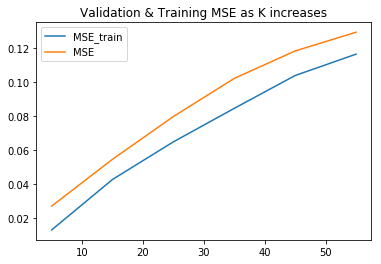

In [212]:
import matplotlib.pyplot as plt

plt.title("Validation & Training MSE as K increases")

plt.plot("K","MSE_train", data = ks)
plt.plot("K","MSE", data = ks)
plt.legend()

It looks appears that $K = 5$ gives us the best MSE.

## Min DF

In [213]:
def test_min_df_vals(min_df):
    
    transformer = FeatureUnion([
                ('desc_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['desc'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = min_df))])),
                ('tags_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['tags'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = min_df))])),
                ('genre_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['genre'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = min_df))]))])
    
    scaler = Normalizer()
    model = KNeighborsRegressor(n_neighbors=5,metric="euclidean")
    pipeline = Pipeline([("vectorizer",transformer),("scaler",scaler),("fit",model)])
    
    val = np.mean(-cross_val_score(pipeline, word_x_train, word_training["agg_rating"], 
            cv=8,scoring = "neg_mean_squared_error",error_score=np.nan))

    return val

In [214]:
min_df = pd.Series(range(0,101,10),index=range(0,101,10)) * 0.01
min_df = pd.DataFrame(min_df).rename(index=str, columns={0:"min_df"})

In [215]:
min_df["MSE"] = min_df["min_df"].apply(test_min_df_vals)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

  FitFailedWarning)


In [216]:
min_df.sort_values("MSE")

,min_df,MSE
20,0.2,0.027135
0,0.0,0.027142
...,...,...
90,0.9,NaN
100,1.0,NaN


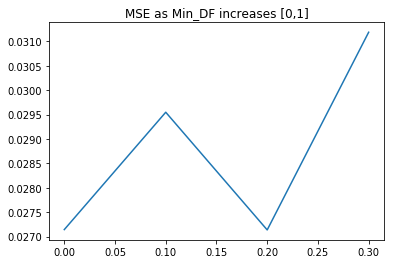

In [217]:
plt.title("MSE as Min_DF increases [0,1]")

plt.plot("min_df","MSE", data = min_df)


It appears that making our Min-DF as 2 gives us the best results.

Let's try focusing in on the interval between $[0.1,0.2]$ to make sure we didn't miss out on a minimum.

In [218]:
min_df = pd.Series(range(100,201,10),index=range(100,201,10)) * 0.001

min_df = pd.DataFrame(min_df).rename(index=str, columns={0:"min_df"})

min_df["MSE"] = min_df["min_df"].apply(test_min_df_vals)

In [219]:
min_df.sort_values("MSE").head()

,min_df,MSE
170,0.17,0.025864
140,0.14,0.026610
180,0.18,0.026696
190,0.19,0.026705
200,0.20,0.027135


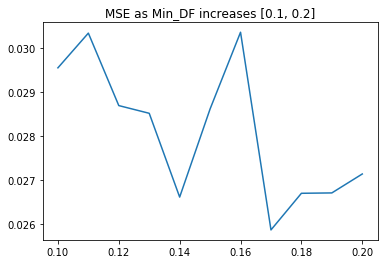

In [220]:
plt.title("MSE as Min_DF increases [0.1, 0.2]")

plt.plot("min_df","MSE", data = min_df)

It looks like it was good that we focused in on that interval $[0.1,0.2]$ since it now shows that a min_df of $0.17$ gives us the best MSE.

## Conclusion

The best model for the text data appears to be $5$ Neighbors KNearestRegressor, using all textual data but reviews and Similar, and having a min_df of $0.17$ for our TF-IDF Vectorizer, which gives us a MSE of $0.025864$.

# Quantitative Variables

In [252]:
quant_training = training_data[["num_eps","datetime","duration","agg_rating"]]

In [253]:
quant_training.corr()

,num_eps,datetime,duration,agg_rating
num_eps,1.000000,-0.096811,0.066826,0.188607
datetime,-0.096811,1.000000,-0.069702,-0.213772
duration,0.066826,-0.069702,1.000000,0.144948
agg_rating,0.188607,-0.213772,0.144948,1.000000


Out of all the possible features, it appears that num_eps has the highest correlation, albeit a weak one.

## Stepwise

In [254]:
def stepwise_Q(column):
    vec = DictVectorizer(sparse = False)
    scaler = StandardScaler()
    model = KNeighborsRegressor(n_neighbors=30)
    pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model)])
    
    return (np.mean(-cross_val_score(pipeline, quant_training[[column]].to_dict(orient="records"),
                                     quant_training["agg_rating"], 
                    cv=5,scoring = "neg_mean_squared_error")))

In [256]:
quant_training_x = quant_training[["num_eps","datetime","duration"]]

columns = quant_training_x.columns
columns = pd.DataFrame(columns).rename(index =str, columns = {0:"columns"})

In [257]:
columns["MSE"] = columns["columns"].apply(stepwise_Q)

In [258]:
columns.sort_values("MSE")

,columns,MSE
0,num_eps,0.228644
2,duration,0.254954
1,datetime,0.263808


It appears that "num_eps" performed the best while datetime did poorly.

## Picking a model

In [259]:
model1 =["num_eps","duration"]
model2 =["num_eps","datetime"]
model3 =["num_eps","duration","datetime"]

models = [[model1],[model2],[model3]]
models = pd.DataFrame(models).rename(index =str, columns = {0:"models"})

In [260]:
def eval_models(features):
    vec = DictVectorizer(sparse = False)
    scaler = StandardScaler()
    model = KNeighborsRegressor(n_neighbors=30)
    pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model)])
    X_dict = pd.DataFrame(quant_training[features]).to_dict(orient="records")
    y = quant_training["agg_rating"]
    return((np.mean(
        -cross_val_score(pipeline, X_dict, y, cv=8,
                         scoring="neg_mean_squared_error")
    )))

In [261]:
models["MSE"] = models["models"].apply(eval_models)

In [262]:
models.sort_values("MSE")

,models,MSE
0,"[num_eps, duration]",0.181908
2,"[num_eps, duration, datetime]",0.184513
1,"[num_eps, datetime]",0.211036


The model with just num_eps and duration performed the best

### Evaluating different $K$ values


In [275]:
def test_k_vals_Q(k):
    vec = DictVectorizer(sparse = False)
    scaler = StandardScaler()
    model = KNeighborsRegressor(n_neighbors=k)
    pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model)])

    return np.mean(-cross_val_score(pipeline, quant_training[model1].to_dict(orient="records"),
                                    quant_training["agg_rating"], 
                                    cv=8, 
                                    scoring = "neg_mean_squared_error"))

def test_k_vals_train_Q(k):
    scaler = Normalizer()
    model = KNeighborsRegressor(n_neighbors=k,metric="euclidean")
    pipeline = Pipeline([("vectorizer",transformer),("scaler",scaler),("fit",model)])
    pipeline.fit(word_x_train,word_training["agg_rating"])
    y_pred = pipeline.predict(word_x_train)
    
    return ((word_training["agg_rating"] - y_pred) ** 2).mean()

In [276]:
ks = pd.Series(range(5,65,10))
ks.index = range(5,65,10)
ks = pd.DataFrame(ks).rename(index= str, columns = {0:"K"})

In [277]:
ks["MSE"] = ks["K"].apply(test_k_vals_Q)
ks["MSE_train"] = ks["K"].apply(test_k_vals_train_Q)

In [278]:
ks.sort_values("MSE").head()

,K,MSE,MSE_train
25,25,0.183165,0.065010
35,35,0.184300,0.084733
15,15,0.185737,0.042845
45,45,0.186646,0.104074
55,55,0.190549,0.116640


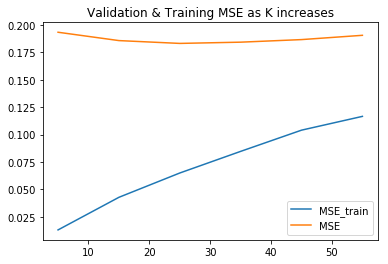

In [279]:
plt.title("Validation & Training MSE as K increases")

plt.plot("K","MSE_train", data = ks)
plt.plot("K","MSE", data = ks)
plt.legend()

It looks appears that $K = 25$ gives us the best MSE.

### Picking Distance Metrics & Scalars

In [287]:
models = [KNeighborsRegressor(n_neighbors=25),
          KNeighborsRegressor(n_neighbors=25,metric='manhattan'),
          KNeighborsRegressor(n_neighbors=25,metric='cosine'),
          KNeighborsRegressor(n_neighbors=25,metric='chebyshev'),
         KNeighborsRegressor(n_neighbors=25,metric='minkowski')]

scalers = [StandardScaler(), MinMaxScaler(),RobustScaler(quantile_range=(25, 75)),Normalizer(),
          QuantileTransformer()]

combinations = []
for model in models:
    for scaler in scalers:
        combinations.append([(model,scaler)])

In [288]:
combinations = pd.DataFrame(combinations).rename(index=str,columns = {0:"model_scalar"})

In [289]:
def eval_combinations(combinations):
    vec = DictVectorizer(sparse = False)
    scaler = combinations[1]
    model = combinations[0]
    pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model)])
    X_dict = pd.DataFrame(quant_training[model1]).to_dict(orient="records")
    y = quant_training["agg_rating"]
    return((np.mean(
        -cross_val_score(pipeline, X_dict, y, cv=8,
                         scoring="neg_mean_squared_error")
    )))

In [290]:
combinations["MSE"] = combinations["model_scalar"].apply(eval_combinations)

In [291]:
combinations.sort_values("MSE").head()

,model_scalar,MSE
16,"(KNeighborsRegressor(algorithm='auto', leaf_si...",0.180859
1,"(KNeighborsRegressor(algorithm='auto', leaf_si...",0.180944
21,"(KNeighborsRegressor(algorithm='auto', leaf_si...",0.180944
6,"(KNeighborsRegressor(algorithm='auto', leaf_si...",0.181443
17,"(KNeighborsRegressor(algorithm='auto', leaf_si...",0.182873


In [292]:
combinations.sort_values("MSE").iloc[0].iloc[0]

(KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='chebyshev',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform'), MinMaxScaler(copy=True, feature_range=(0, 1)))

The model that used the `Chebyshev` metric and `MinMaxScaler` Scaler performed the best

In [293]:
model = combinations.sort_values("MSE").iloc[0].iloc[0][0]
scaler = combinations.sort_values("MSE").iloc[0].iloc[0][1]
vec = DictVectorizer(sparse = False)

### Conclusion

It appears for our quantitiative variables that a KNearestRegressor with 25 Neighbors, just num_eps and duration, Chebyshev metric and MinMax Scalers performs the best. 

# Ensembling Text & Quantitative Features

In [298]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class RegressionEnsembler(BaseEstimator, RegressorMixin):
    
    def __init__(self, estimators):
        self.estimators = estimators
        
    def fit(self, data, y1):
        
        vec1 = FeatureUnion([
                ('desc_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['desc'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = 0.17))])),
                ('tags_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['tags'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = 0.17))])),
                ('genre_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['genre'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = 0.17))]))])
        
        scaler1 = Normalizer()
    
        vec2 = DictVectorizer(sparse=False)
        
        scaler2 = Normalizer(copy=True, norm='l2')
        
        
        X_train1 = data[["desc","tags","genre"]]
        
        X_train2 = data[["num_eps","datetime","rating_y","duration"]]
        
        vec1.fit(X_train1)
        vec2.fit(X_train2.to_dict(orient="records"))
        
        X_train_tran1 = vec1.transform(X_train1)
        X_train_tran2 = vec2.transform(X_train2.to_dict(orient="records"))
        
        scaler1.fit(X_train_tran1)
        scaler2.fit(X_train_tran2)
        
        X_train_tran_sc1 = scaler1.transform(X_train_tran1)
        X_train_tran_sc2 = scaler2.transform(X_train_tran2)
        
        self.X1_ = X_train1
        self.X2_ = X_train2
        self.y_ =  y1
        
        self.estimators[0] = self.estimators[0].fit(X_train_tran_sc1,y1)
        self.estimators[1] = self.estimators[1].fit(X_train_tran_sc2,y1)
        
        
    def predict(self, data):
        vec1 = FeatureUnion([
                ('desc_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['desc'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = 0.17))])),
                ('tags_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['tags'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = 0.17))])),
                ('genre_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['genre'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(min_df = 0.17))]))])
        
        scaler1 = Normalizer()
    
        vec2 = DictVectorizer(sparse=False)
        
        scaler2 = MinMaxScaler()

        vec1.fit(self.X1_)
        vec2.fit(self.X2_.to_dict(orient="records"))
        
        X_train_tran1 = vec1.transform(self.X1_)
        X_train_tran2 = vec2.transform(self.X2_.to_dict(orient="records"))
        
        scaler1.fit(X_train_tran1)
        scaler2.fit(X_train_tran2)
        
        X_train_tran_sc1 = scaler1.transform(X_train_tran1)
        X_train_tran_sc2 = scaler2.transform(X_train_tran2)
        
        X_new1 = data[["desc","tags","genre"]]
        
        X_new2 = data[["num_eps","datetime","rating_y","duration"]]

        X_new_tran1 = vec1.transform(X_new1)
        X_new_tran2 = vec2.transform(X_new2.to_dict(orient="records"))

        X_new_tran_sc1 = scaler1.transform(X_new_tran1)
        X_new_tran_sc2 = scaler2.transform(X_new_tran2)

        pred1 = self.estimators[0].predict(X_new_tran_sc1)
        pred2 = self.estimators[1].predict(X_new_tran_sc2)
        return (pred1 + pred2)/2

In [299]:
model1 = KNeighborsRegressor(n_neighbors=5,metric="euclidean")

model2 = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='chebyshev',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

In [300]:
(-cross_val_score(RegressionEnsembler([model1, model2]),
                         training_data,
                         training_data["agg_rating"],
                         cv=8,
                         scoring="neg_mean_squared_error").mean())

0.11921578634668603

We get a MSE of $0.119215$ which is not better than just our model using textual data.